## Weakly Supervised Instance Segmentation using Class Peak Response 
### Demo code

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.misc import imresize

Access PRM through [Nest](https://github.com/ZhouYanzhao/Nest)

In [4]:
from nest import modules, run_tasks

### Train a PRM-augmented classification network using image-level labels

In [5]:
run_tasks('./config.yml')

[2018-09-29 20:25:56,885] _name: network_trainer
data_loaders:
  _name: fetch_data
  dataset: 
    _name: pascal_voc_classification
    data_dir: ./datasets/VOCdevkit
    year: 2012
  batch_size: 2
  num_workers: 4
  transform:
    _name: image_transform
    image_size: [448, 448]
    mean: [0.485, 0.456, 0.406]
    std: [0.229, 0.224, 0.225]
  train_augmentation:
    horizontal_flip: 0.5
  train_splits:
    - trainval
model:
  _name: peak_response_mapping
  backbone:
    _name: fc_resnet50
  win_size: 3
  sub_pixel_locating_factor: 8
  enable_peak_stimulation: true
criterion:
  _name: multilabel_soft_margin_loss
  difficult_samples: yes
optimizer:
  _name: sgd_optimizer
  lr: 0.01
  momentum: 0.9
  weight_decay: 1.0e-4
parameter:
  _name: finetune
  base_lr: 0.01
  groups:
    'features': 0.01
meters:
  loss:
    _name: loss_meter
max_epoch: 1
device: cuda
hooks:
  on_start:
    -
      _name: print_state
      formats:
        - '@CONFIG'
        - 'Model: {model}'
      join_str: '\

)


Processing is canceled by user.


### Inference setup

In [17]:
# object categories
class_names = modules.pascal_voc_object_categories()
print('Object categories: ' + ', '.join(class_names))

Object categories: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike


In [6]:
image_size = 448
# image pre-processor
transformer = modules.image_transform(
    image_size = [image_size, image_size],
    augmentation = dict(),
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225])

print(transformer)

Compose(
    Resize(size=(448, 448), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


### Classification networks in fully convolutional manner

In [10]:
backbone = modules.fc_resnet50(num_classes=14, pretrained=False)
print(backbone)

FC_ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, ke

)


### Equipped  with Peak Response Mapping

In [11]:
model = modules.peak_response_mapping(backbone)

In [17]:
# loaded pre-trained weights
model = nn.DataParallel(model)
state = torch.load('./snapshots/model_latest.pt')
model.load_state_dict(state['model'])
# model.load_state_dict({k.replace('module.',''):v for k,v in torch.load('./snapshots/model_latest.pt')['model'].items()})
model = model.module.cuda()

RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.module.module.module.module.0.features.0.weight", "module.module.module.module.module.0.features.1.weight", "module.module.module.module.module.0.features.1.bias", "module.module.module.module.module.0.features.1.running_mean", "module.module.module.module.module.0.features.1.running_var", "module.module.module.module.module.0.features.4.0.conv1.weight", "module.module.module.module.module.0.features.4.0.bn1.weight", "module.module.module.module.module.0.features.4.0.bn1.bias", "module.module.module.module.module.0.features.4.0.bn1.running_mean", "module.module.module.module.module.0.features.4.0.bn1.running_var", "module.module.module.module.module.0.features.4.0.conv2.weight", "module.module.module.module.module.0.features.4.0.bn2.weight", "module.module.module.module.module.0.features.4.0.bn2.bias", "module.module.module.module.module.0.features.4.0.bn2.running_mean", "module.module.module.module.module.0.features.4.0.bn2.running_var", "module.module.module.module.module.0.features.4.0.conv3.weight", "module.module.module.module.module.0.features.4.0.bn3.weight", "module.module.module.module.module.0.features.4.0.bn3.bias", "module.module.module.module.module.0.features.4.0.bn3.running_mean", "module.module.module.module.module.0.features.4.0.bn3.running_var", "module.module.module.module.module.0.features.4.0.downsample.0.weight", "module.module.module.module.module.0.features.4.0.downsample.1.weight", "module.module.module.module.module.0.features.4.0.downsample.1.bias", "module.module.module.module.module.0.features.4.0.downsample.1.running_mean", "module.module.module.module.module.0.features.4.0.downsample.1.running_var", "module.module.module.module.module.0.features.4.1.conv1.weight", "module.module.module.module.module.0.features.4.1.bn1.weight", "module.module.module.module.module.0.features.4.1.bn1.bias", "module.module.module.module.module.0.features.4.1.bn1.running_mean", "module.module.module.module.module.0.features.4.1.bn1.running_var", "module.module.module.module.module.0.features.4.1.conv2.weight", "module.module.module.module.module.0.features.4.1.bn2.weight", "module.module.module.module.module.0.features.4.1.bn2.bias", "module.module.module.module.module.0.features.4.1.bn2.running_mean", "module.module.module.module.module.0.features.4.1.bn2.running_var", "module.module.module.module.module.0.features.4.1.conv3.weight", "module.module.module.module.module.0.features.4.1.bn3.weight", "module.module.module.module.module.0.features.4.1.bn3.bias", "module.module.module.module.module.0.features.4.1.bn3.running_mean", "module.module.module.module.module.0.features.4.1.bn3.running_var", "module.module.module.module.module.0.features.4.2.conv1.weight", "module.module.module.module.module.0.features.4.2.bn1.weight", "module.module.module.module.module.0.features.4.2.bn1.bias", "module.module.module.module.module.0.features.4.2.bn1.running_mean", "module.module.module.module.module.0.features.4.2.bn1.running_var", "module.module.module.module.module.0.features.4.2.conv2.weight", "module.module.module.module.module.0.features.4.2.bn2.weight", "module.module.module.module.module.0.features.4.2.bn2.bias", "module.module.module.module.module.0.features.4.2.bn2.running_mean", "module.module.module.module.module.0.features.4.2.bn2.running_var", "module.module.module.module.module.0.features.4.2.conv3.weight", "module.module.module.module.module.0.features.4.2.bn3.weight", "module.module.module.module.module.0.features.4.2.bn3.bias", "module.module.module.module.module.0.features.4.2.bn3.running_mean", "module.module.module.module.module.0.features.4.2.bn3.running_var", "module.module.module.module.module.0.features.5.0.conv1.weight", "module.module.module.module.module.0.features.5.0.bn1.weight", "module.module.module.module.module.0.features.5.0.bn1.bias", "module.module.module.module.module.0.features.5.0.bn1.running_mean", "module.module.module.module.module.0.features.5.0.bn1.running_var", "module.module.module.module.module.0.features.5.0.conv2.weight", "module.module.module.module.module.0.features.5.0.bn2.weight", "module.module.module.module.module.0.features.5.0.bn2.bias", "module.module.module.module.module.0.features.5.0.bn2.running_mean", "module.module.module.module.module.0.features.5.0.bn2.running_var", "module.module.module.module.module.0.features.5.0.conv3.weight", "module.module.module.module.module.0.features.5.0.bn3.weight", "module.module.module.module.module.0.features.5.0.bn3.bias", "module.module.module.module.module.0.features.5.0.bn3.running_mean", "module.module.module.module.module.0.features.5.0.bn3.running_var", "module.module.module.module.module.0.features.5.0.downsample.0.weight", "module.module.module.module.module.0.features.5.0.downsample.1.weight", "module.module.module.module.module.0.features.5.0.downsample.1.bias", "module.module.module.module.module.0.features.5.0.downsample.1.running_mean", "module.module.module.module.module.0.features.5.0.downsample.1.running_var", "module.module.module.module.module.0.features.5.1.conv1.weight", "module.module.module.module.module.0.features.5.1.bn1.weight", "module.module.module.module.module.0.features.5.1.bn1.bias", "module.module.module.module.module.0.features.5.1.bn1.running_mean", "module.module.module.module.module.0.features.5.1.bn1.running_var", "module.module.module.module.module.0.features.5.1.conv2.weight", "module.module.module.module.module.0.features.5.1.bn2.weight", "module.module.module.module.module.0.features.5.1.bn2.bias", "module.module.module.module.module.0.features.5.1.bn2.running_mean", "module.module.module.module.module.0.features.5.1.bn2.running_var", "module.module.module.module.module.0.features.5.1.conv3.weight", "module.module.module.module.module.0.features.5.1.bn3.weight", "module.module.module.module.module.0.features.5.1.bn3.bias", "module.module.module.module.module.0.features.5.1.bn3.running_mean", "module.module.module.module.module.0.features.5.1.bn3.running_var", "module.module.module.module.module.0.features.5.2.conv1.weight", "module.module.module.module.module.0.features.5.2.bn1.weight", "module.module.module.module.module.0.features.5.2.bn1.bias", "module.module.module.module.module.0.features.5.2.bn1.running_mean", "module.module.module.module.module.0.features.5.2.bn1.running_var", "module.module.module.module.module.0.features.5.2.conv2.weight", "module.module.module.module.module.0.features.5.2.bn2.weight", "module.module.module.module.module.0.features.5.2.bn2.bias", "module.module.module.module.module.0.features.5.2.bn2.running_mean", "module.module.module.module.module.0.features.5.2.bn2.running_var", "module.module.module.module.module.0.features.5.2.conv3.weight", "module.module.module.module.module.0.features.5.2.bn3.weight", "module.module.module.module.module.0.features.5.2.bn3.bias", "module.module.module.module.module.0.features.5.2.bn3.running_mean", "module.module.module.module.module.0.features.5.2.bn3.running_var", "module.module.module.module.module.0.features.5.3.conv1.weight", "module.module.module.module.module.0.features.5.3.bn1.weight", "module.module.module.module.module.0.features.5.3.bn1.bias", "module.module.module.module.module.0.features.5.3.bn1.running_mean", "module.module.module.module.module.0.features.5.3.bn1.running_var", "module.module.module.module.module.0.features.5.3.conv2.weight", "module.module.module.module.module.0.features.5.3.bn2.weight", "module.module.module.module.module.0.features.5.3.bn2.bias", "module.module.module.module.module.0.features.5.3.bn2.running_mean", "module.module.module.module.module.0.features.5.3.bn2.running_var", "module.module.module.module.module.0.features.5.3.conv3.weight", "module.module.module.module.module.0.features.5.3.bn3.weight", "module.module.module.module.module.0.features.5.3.bn3.bias", "module.module.module.module.module.0.features.5.3.bn3.running_mean", "module.module.module.module.module.0.features.5.3.bn3.running_var", "module.module.module.module.module.0.features.6.0.conv1.weight", "module.module.module.module.module.0.features.6.0.bn1.weight", "module.module.module.module.module.0.features.6.0.bn1.bias", "module.module.module.module.module.0.features.6.0.bn1.running_mean", "module.module.module.module.module.0.features.6.0.bn1.running_var", "module.module.module.module.module.0.features.6.0.conv2.weight", "module.module.module.module.module.0.features.6.0.bn2.weight", "module.module.module.module.module.0.features.6.0.bn2.bias", "module.module.module.module.module.0.features.6.0.bn2.running_mean", "module.module.module.module.module.0.features.6.0.bn2.running_var", "module.module.module.module.module.0.features.6.0.conv3.weight", "module.module.module.module.module.0.features.6.0.bn3.weight", "module.module.module.module.module.0.features.6.0.bn3.bias", "module.module.module.module.module.0.features.6.0.bn3.running_mean", "module.module.module.module.module.0.features.6.0.bn3.running_var", "module.module.module.module.module.0.features.6.0.downsample.0.weight", "module.module.module.module.module.0.features.6.0.downsample.1.weight", "module.module.module.module.module.0.features.6.0.downsample.1.bias", "module.module.module.module.module.0.features.6.0.downsample.1.running_mean", "module.module.module.module.module.0.features.6.0.downsample.1.running_var", "module.module.module.module.module.0.features.6.1.conv1.weight", "module.module.module.module.module.0.features.6.1.bn1.weight", "module.module.module.module.module.0.features.6.1.bn1.bias", "module.module.module.module.module.0.features.6.1.bn1.running_mean", "module.module.module.module.module.0.features.6.1.bn1.running_var", "module.module.module.module.module.0.features.6.1.conv2.weight", "module.module.module.module.module.0.features.6.1.bn2.weight", "module.module.module.module.module.0.features.6.1.bn2.bias", "module.module.module.module.module.0.features.6.1.bn2.running_mean", "module.module.module.module.module.0.features.6.1.bn2.running_var", "module.module.module.module.module.0.features.6.1.conv3.weight", "module.module.module.module.module.0.features.6.1.bn3.weight", "module.module.module.module.module.0.features.6.1.bn3.bias", "module.module.module.module.module.0.features.6.1.bn3.running_mean", "module.module.module.module.module.0.features.6.1.bn3.running_var", "module.module.module.module.module.0.features.6.2.conv1.weight", "module.module.module.module.module.0.features.6.2.bn1.weight", "module.module.module.module.module.0.features.6.2.bn1.bias", "module.module.module.module.module.0.features.6.2.bn1.running_mean", "module.module.module.module.module.0.features.6.2.bn1.running_var", "module.module.module.module.module.0.features.6.2.conv2.weight", "module.module.module.module.module.0.features.6.2.bn2.weight", "module.module.module.module.module.0.features.6.2.bn2.bias", "module.module.module.module.module.0.features.6.2.bn2.running_mean", "module.module.module.module.module.0.features.6.2.bn2.running_var", "module.module.module.module.module.0.features.6.2.conv3.weight", "module.module.module.module.module.0.features.6.2.bn3.weight", "module.module.module.module.module.0.features.6.2.bn3.bias", "module.module.module.module.module.0.features.6.2.bn3.running_mean", "module.module.module.module.module.0.features.6.2.bn3.running_var", "module.module.module.module.module.0.features.6.3.conv1.weight", "module.module.module.module.module.0.features.6.3.bn1.weight", "module.module.module.module.module.0.features.6.3.bn1.bias", "module.module.module.module.module.0.features.6.3.bn1.running_mean", "module.module.module.module.module.0.features.6.3.bn1.running_var", "module.module.module.module.module.0.features.6.3.conv2.weight", "module.module.module.module.module.0.features.6.3.bn2.weight", "module.module.module.module.module.0.features.6.3.bn2.bias", "module.module.module.module.module.0.features.6.3.bn2.running_mean", "module.module.module.module.module.0.features.6.3.bn2.running_var", "module.module.module.module.module.0.features.6.3.conv3.weight", "module.module.module.module.module.0.features.6.3.bn3.weight", "module.module.module.module.module.0.features.6.3.bn3.bias", "module.module.module.module.module.0.features.6.3.bn3.running_mean", "module.module.module.module.module.0.features.6.3.bn3.running_var", "module.module.module.module.module.0.features.6.4.conv1.weight", "module.module.module.module.module.0.features.6.4.bn1.weight", "module.module.module.module.module.0.features.6.4.bn1.bias", "module.module.module.module.module.0.features.6.4.bn1.running_mean", "module.module.module.module.module.0.features.6.4.bn1.running_var", "module.module.module.module.module.0.features.6.4.conv2.weight", "module.module.module.module.module.0.features.6.4.bn2.weight", "module.module.module.module.module.0.features.6.4.bn2.bias", "module.module.module.module.module.0.features.6.4.bn2.running_mean", "module.module.module.module.module.0.features.6.4.bn2.running_var", "module.module.module.module.module.0.features.6.4.conv3.weight", "module.module.module.module.module.0.features.6.4.bn3.weight", "module.module.module.module.module.0.features.6.4.bn3.bias", "module.module.module.module.module.0.features.6.4.bn3.running_mean", "module.module.module.module.module.0.features.6.4.bn3.running_var", "module.module.module.module.module.0.features.6.5.conv1.weight", "module.module.module.module.module.0.features.6.5.bn1.weight", "module.module.module.module.module.0.features.6.5.bn1.bias", "module.module.module.module.module.0.features.6.5.bn1.running_mean", "module.module.module.module.module.0.features.6.5.bn1.running_var", "module.module.module.module.module.0.features.6.5.conv2.weight", "module.module.module.module.module.0.features.6.5.bn2.weight", "module.module.module.module.module.0.features.6.5.bn2.bias", "module.module.module.module.module.0.features.6.5.bn2.running_mean", "module.module.module.module.module.0.features.6.5.bn2.running_var", "module.module.module.module.module.0.features.6.5.conv3.weight", "module.module.module.module.module.0.features.6.5.bn3.weight", "module.module.module.module.module.0.features.6.5.bn3.bias", "module.module.module.module.module.0.features.6.5.bn3.running_mean", "module.module.module.module.module.0.features.6.5.bn3.running_var", "module.module.module.module.module.0.features.7.0.conv1.weight", "module.module.module.module.module.0.features.7.0.bn1.weight", "module.module.module.module.module.0.features.7.0.bn1.bias", "module.module.module.module.module.0.features.7.0.bn1.running_mean", "module.module.module.module.module.0.features.7.0.bn1.running_var", "module.module.module.module.module.0.features.7.0.conv2.weight", "module.module.module.module.module.0.features.7.0.bn2.weight", "module.module.module.module.module.0.features.7.0.bn2.bias", "module.module.module.module.module.0.features.7.0.bn2.running_mean", "module.module.module.module.module.0.features.7.0.bn2.running_var", "module.module.module.module.module.0.features.7.0.conv3.weight", "module.module.module.module.module.0.features.7.0.bn3.weight", "module.module.module.module.module.0.features.7.0.bn3.bias", "module.module.module.module.module.0.features.7.0.bn3.running_mean", "module.module.module.module.module.0.features.7.0.bn3.running_var", "module.module.module.module.module.0.features.7.0.downsample.0.weight", "module.module.module.module.module.0.features.7.0.downsample.1.weight", "module.module.module.module.module.0.features.7.0.downsample.1.bias", "module.module.module.module.module.0.features.7.0.downsample.1.running_mean", "module.module.module.module.module.0.features.7.0.downsample.1.running_var", "module.module.module.module.module.0.features.7.1.conv1.weight", "module.module.module.module.module.0.features.7.1.bn1.weight", "module.module.module.module.module.0.features.7.1.bn1.bias", "module.module.module.module.module.0.features.7.1.bn1.running_mean", "module.module.module.module.module.0.features.7.1.bn1.running_var", "module.module.module.module.module.0.features.7.1.conv2.weight", "module.module.module.module.module.0.features.7.1.bn2.weight", "module.module.module.module.module.0.features.7.1.bn2.bias", "module.module.module.module.module.0.features.7.1.bn2.running_mean", "module.module.module.module.module.0.features.7.1.bn2.running_var", "module.module.module.module.module.0.features.7.1.conv3.weight", "module.module.module.module.module.0.features.7.1.bn3.weight", "module.module.module.module.module.0.features.7.1.bn3.bias", "module.module.module.module.module.0.features.7.1.bn3.running_mean", "module.module.module.module.module.0.features.7.1.bn3.running_var", "module.module.module.module.module.0.features.7.2.conv1.weight", "module.module.module.module.module.0.features.7.2.bn1.weight", "module.module.module.module.module.0.features.7.2.bn1.bias", "module.module.module.module.module.0.features.7.2.bn1.running_mean", "module.module.module.module.module.0.features.7.2.bn1.running_var", "module.module.module.module.module.0.features.7.2.conv2.weight", "module.module.module.module.module.0.features.7.2.bn2.weight", "module.module.module.module.module.0.features.7.2.bn2.bias", "module.module.module.module.module.0.features.7.2.bn2.running_mean", "module.module.module.module.module.0.features.7.2.bn2.running_var", "module.module.module.module.module.0.features.7.2.conv3.weight", "module.module.module.module.module.0.features.7.2.bn3.weight", "module.module.module.module.module.0.features.7.2.bn3.bias", "module.module.module.module.module.0.features.7.2.bn3.running_mean", "module.module.module.module.module.0.features.7.2.bn3.running_var", "module.module.module.module.module.0.classifier.0.weight", "module.module.module.module.module.0.classifier.0.bias". 
	Unexpected key(s) in state_dict: "0.features.0.weight", "0.features.1.weight", "0.features.1.bias", "0.features.1.running_mean", "0.features.1.running_var", "0.features.1.num_batches_tracked", "0.features.4.0.conv1.weight", "0.features.4.0.bn1.weight", "0.features.4.0.bn1.bias", "0.features.4.0.bn1.running_mean", "0.features.4.0.bn1.running_var", "0.features.4.0.bn1.num_batches_tracked", "0.features.4.0.conv2.weight", "0.features.4.0.bn2.weight", "0.features.4.0.bn2.bias", "0.features.4.0.bn2.running_mean", "0.features.4.0.bn2.running_var", "0.features.4.0.bn2.num_batches_tracked", "0.features.4.0.conv3.weight", "0.features.4.0.bn3.weight", "0.features.4.0.bn3.bias", "0.features.4.0.bn3.running_mean", "0.features.4.0.bn3.running_var", "0.features.4.0.bn3.num_batches_tracked", "0.features.4.0.downsample.0.weight", "0.features.4.0.downsample.1.weight", "0.features.4.0.downsample.1.bias", "0.features.4.0.downsample.1.running_mean", "0.features.4.0.downsample.1.running_var", "0.features.4.0.downsample.1.num_batches_tracked", "0.features.4.1.conv1.weight", "0.features.4.1.bn1.weight", "0.features.4.1.bn1.bias", "0.features.4.1.bn1.running_mean", "0.features.4.1.bn1.running_var", "0.features.4.1.bn1.num_batches_tracked", "0.features.4.1.conv2.weight", "0.features.4.1.bn2.weight", "0.features.4.1.bn2.bias", "0.features.4.1.bn2.running_mean", "0.features.4.1.bn2.running_var", "0.features.4.1.bn2.num_batches_tracked", "0.features.4.1.conv3.weight", "0.features.4.1.bn3.weight", "0.features.4.1.bn3.bias", "0.features.4.1.bn3.running_mean", "0.features.4.1.bn3.running_var", "0.features.4.1.bn3.num_batches_tracked", "0.features.4.2.conv1.weight", "0.features.4.2.bn1.weight", "0.features.4.2.bn1.bias", "0.features.4.2.bn1.running_mean", "0.features.4.2.bn1.running_var", "0.features.4.2.bn1.num_batches_tracked", "0.features.4.2.conv2.weight", "0.features.4.2.bn2.weight", "0.features.4.2.bn2.bias", "0.features.4.2.bn2.running_mean", "0.features.4.2.bn2.running_var", "0.features.4.2.bn2.num_batches_tracked", "0.features.4.2.conv3.weight", "0.features.4.2.bn3.weight", "0.features.4.2.bn3.bias", "0.features.4.2.bn3.running_mean", "0.features.4.2.bn3.running_var", "0.features.4.2.bn3.num_batches_tracked", "0.features.5.0.conv1.weight", "0.features.5.0.bn1.weight", "0.features.5.0.bn1.bias", "0.features.5.0.bn1.running_mean", "0.features.5.0.bn1.running_var", "0.features.5.0.bn1.num_batches_tracked", "0.features.5.0.conv2.weight", "0.features.5.0.bn2.weight", "0.features.5.0.bn2.bias", "0.features.5.0.bn2.running_mean", "0.features.5.0.bn2.running_var", "0.features.5.0.bn2.num_batches_tracked", "0.features.5.0.conv3.weight", "0.features.5.0.bn3.weight", "0.features.5.0.bn3.bias", "0.features.5.0.bn3.running_mean", "0.features.5.0.bn3.running_var", "0.features.5.0.bn3.num_batches_tracked", "0.features.5.0.downsample.0.weight", "0.features.5.0.downsample.1.weight", "0.features.5.0.downsample.1.bias", "0.features.5.0.downsample.1.running_mean", "0.features.5.0.downsample.1.running_var", "0.features.5.0.downsample.1.num_batches_tracked", "0.features.5.1.conv1.weight", "0.features.5.1.bn1.weight", "0.features.5.1.bn1.bias", "0.features.5.1.bn1.running_mean", "0.features.5.1.bn1.running_var", "0.features.5.1.bn1.num_batches_tracked", "0.features.5.1.conv2.weight", "0.features.5.1.bn2.weight", "0.features.5.1.bn2.bias", "0.features.5.1.bn2.running_mean", "0.features.5.1.bn2.running_var", "0.features.5.1.bn2.num_batches_tracked", "0.features.5.1.conv3.weight", "0.features.5.1.bn3.weight", "0.features.5.1.bn3.bias", "0.features.5.1.bn3.running_mean", "0.features.5.1.bn3.running_var", "0.features.5.1.bn3.num_batches_tracked", "0.features.5.2.conv1.weight", "0.features.5.2.bn1.weight", "0.features.5.2.bn1.bias", "0.features.5.2.bn1.running_mean", "0.features.5.2.bn1.running_var", "0.features.5.2.bn1.num_batches_tracked", "0.features.5.2.conv2.weight", "0.features.5.2.bn2.weight", "0.features.5.2.bn2.bias", "0.features.5.2.bn2.running_mean", "0.features.5.2.bn2.running_var", "0.features.5.2.bn2.num_batches_tracked", "0.features.5.2.conv3.weight", "0.features.5.2.bn3.weight", "0.features.5.2.bn3.bias", "0.features.5.2.bn3.running_mean", "0.features.5.2.bn3.running_var", "0.features.5.2.bn3.num_batches_tracked", "0.features.5.3.conv1.weight", "0.features.5.3.bn1.weight", "0.features.5.3.bn1.bias", "0.features.5.3.bn1.running_mean", "0.features.5.3.bn1.running_var", "0.features.5.3.bn1.num_batches_tracked", "0.features.5.3.conv2.weight", "0.features.5.3.bn2.weight", "0.features.5.3.bn2.bias", "0.features.5.3.bn2.running_mean", "0.features.5.3.bn2.running_var", "0.features.5.3.bn2.num_batches_tracked", "0.features.5.3.conv3.weight", "0.features.5.3.bn3.weight", "0.features.5.3.bn3.bias", "0.features.5.3.bn3.running_mean", "0.features.5.3.bn3.running_var", "0.features.5.3.bn3.num_batches_tracked", "0.features.6.0.conv1.weight", "0.features.6.0.bn1.weight", "0.features.6.0.bn1.bias", "0.features.6.0.bn1.running_mean", "0.features.6.0.bn1.running_var", "0.features.6.0.bn1.num_batches_tracked", "0.features.6.0.conv2.weight", "0.features.6.0.bn2.weight", "0.features.6.0.bn2.bias", "0.features.6.0.bn2.running_mean", "0.features.6.0.bn2.running_var", "0.features.6.0.bn2.num_batches_tracked", "0.features.6.0.conv3.weight", "0.features.6.0.bn3.weight", "0.features.6.0.bn3.bias", "0.features.6.0.bn3.running_mean", "0.features.6.0.bn3.running_var", "0.features.6.0.bn3.num_batches_tracked", "0.features.6.0.downsample.0.weight", "0.features.6.0.downsample.1.weight", "0.features.6.0.downsample.1.bias", "0.features.6.0.downsample.1.running_mean", "0.features.6.0.downsample.1.running_var", "0.features.6.0.downsample.1.num_batches_tracked", "0.features.6.1.conv1.weight", "0.features.6.1.bn1.weight", "0.features.6.1.bn1.bias", "0.features.6.1.bn1.running_mean", "0.features.6.1.bn1.running_var", "0.features.6.1.bn1.num_batches_tracked", "0.features.6.1.conv2.weight", "0.features.6.1.bn2.weight", "0.features.6.1.bn2.bias", "0.features.6.1.bn2.running_mean", "0.features.6.1.bn2.running_var", "0.features.6.1.bn2.num_batches_tracked", "0.features.6.1.conv3.weight", "0.features.6.1.bn3.weight", "0.features.6.1.bn3.bias", "0.features.6.1.bn3.running_mean", "0.features.6.1.bn3.running_var", "0.features.6.1.bn3.num_batches_tracked", "0.features.6.2.conv1.weight", "0.features.6.2.bn1.weight", "0.features.6.2.bn1.bias", "0.features.6.2.bn1.running_mean", "0.features.6.2.bn1.running_var", "0.features.6.2.bn1.num_batches_tracked", "0.features.6.2.conv2.weight", "0.features.6.2.bn2.weight", "0.features.6.2.bn2.bias", "0.features.6.2.bn2.running_mean", "0.features.6.2.bn2.running_var", "0.features.6.2.bn2.num_batches_tracked", "0.features.6.2.conv3.weight", "0.features.6.2.bn3.weight", "0.features.6.2.bn3.bias", "0.features.6.2.bn3.running_mean", "0.features.6.2.bn3.running_var", "0.features.6.2.bn3.num_batches_tracked", "0.features.6.3.conv1.weight", "0.features.6.3.bn1.weight", "0.features.6.3.bn1.bias", "0.features.6.3.bn1.running_mean", "0.features.6.3.bn1.running_var", "0.features.6.3.bn1.num_batches_tracked", "0.features.6.3.conv2.weight", "0.features.6.3.bn2.weight", "0.features.6.3.bn2.bias", "0.features.6.3.bn2.running_mean", "0.features.6.3.bn2.running_var", "0.features.6.3.bn2.num_batches_tracked", "0.features.6.3.conv3.weight", "0.features.6.3.bn3.weight", "0.features.6.3.bn3.bias", "0.features.6.3.bn3.running_mean", "0.features.6.3.bn3.running_var", "0.features.6.3.bn3.num_batches_tracked", "0.features.6.4.conv1.weight", "0.features.6.4.bn1.weight", "0.features.6.4.bn1.bias", "0.features.6.4.bn1.running_mean", "0.features.6.4.bn1.running_var", "0.features.6.4.bn1.num_batches_tracked", "0.features.6.4.conv2.weight", "0.features.6.4.bn2.weight", "0.features.6.4.bn2.bias", "0.features.6.4.bn2.running_mean", "0.features.6.4.bn2.running_var", "0.features.6.4.bn2.num_batches_tracked", "0.features.6.4.conv3.weight", "0.features.6.4.bn3.weight", "0.features.6.4.bn3.bias", "0.features.6.4.bn3.running_mean", "0.features.6.4.bn3.running_var", "0.features.6.4.bn3.num_batches_tracked", "0.features.6.5.conv1.weight", "0.features.6.5.bn1.weight", "0.features.6.5.bn1.bias", "0.features.6.5.bn1.running_mean", "0.features.6.5.bn1.running_var", "0.features.6.5.bn1.num_batches_tracked", "0.features.6.5.conv2.weight", "0.features.6.5.bn2.weight", "0.features.6.5.bn2.bias", "0.features.6.5.bn2.running_mean", "0.features.6.5.bn2.running_var", "0.features.6.5.bn2.num_batches_tracked", "0.features.6.5.conv3.weight", "0.features.6.5.bn3.weight", "0.features.6.5.bn3.bias", "0.features.6.5.bn3.running_mean", "0.features.6.5.bn3.running_var", "0.features.6.5.bn3.num_batches_tracked", "0.features.7.0.conv1.weight", "0.features.7.0.bn1.weight", "0.features.7.0.bn1.bias", "0.features.7.0.bn1.running_mean", "0.features.7.0.bn1.running_var", "0.features.7.0.bn1.num_batches_tracked", "0.features.7.0.conv2.weight", "0.features.7.0.bn2.weight", "0.features.7.0.bn2.bias", "0.features.7.0.bn2.running_mean", "0.features.7.0.bn2.running_var", "0.features.7.0.bn2.num_batches_tracked", "0.features.7.0.conv3.weight", "0.features.7.0.bn3.weight", "0.features.7.0.bn3.bias", "0.features.7.0.bn3.running_mean", "0.features.7.0.bn3.running_var", "0.features.7.0.bn3.num_batches_tracked", "0.features.7.0.downsample.0.weight", "0.features.7.0.downsample.1.weight", "0.features.7.0.downsample.1.bias", "0.features.7.0.downsample.1.running_mean", "0.features.7.0.downsample.1.running_var", "0.features.7.0.downsample.1.num_batches_tracked", "0.features.7.1.conv1.weight", "0.features.7.1.bn1.weight", "0.features.7.1.bn1.bias", "0.features.7.1.bn1.running_mean", "0.features.7.1.bn1.running_var", "0.features.7.1.bn1.num_batches_tracked", "0.features.7.1.conv2.weight", "0.features.7.1.bn2.weight", "0.features.7.1.bn2.bias", "0.features.7.1.bn2.running_mean", "0.features.7.1.bn2.running_var", "0.features.7.1.bn2.num_batches_tracked", "0.features.7.1.conv3.weight", "0.features.7.1.bn3.weight", "0.features.7.1.bn3.bias", "0.features.7.1.bn3.running_mean", "0.features.7.1.bn3.running_var", "0.features.7.1.bn3.num_batches_tracked", "0.features.7.2.conv1.weight", "0.features.7.2.bn1.weight", "0.features.7.2.bn1.bias", "0.features.7.2.bn1.running_mean", "0.features.7.2.bn1.running_var", "0.features.7.2.bn1.num_batches_tracked", "0.features.7.2.conv2.weight", "0.features.7.2.bn2.weight", "0.features.7.2.bn2.bias", "0.features.7.2.bn2.running_mean", "0.features.7.2.bn2.running_var", "0.features.7.2.bn2.num_batches_tracked", "0.features.7.2.conv3.weight", "0.features.7.2.bn3.weight", "0.features.7.2.bn3.bias", "0.features.7.2.bn3.running_mean", "0.features.7.2.bn3.running_var", "0.features.7.2.bn3.num_batches_tracked", "0.classifier.0.weight", "0.classifier.0.bias". 

### Load demo images and pre-computed object proposals

I am here


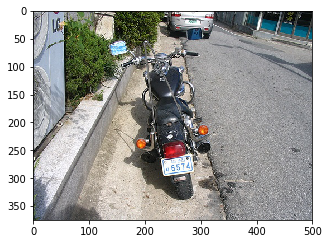

In [11]:
# change the idx to test different samples
idx = 2
raw_img = PIL.Image.open('./data/1.png').convert('RGB')
input_var = transformer(raw_img).unsqueeze(0).cuda().requires_grad_()
with open('./data/sample%d.json' % idx, 'r') as f:
    proposals = list(map(modules.rle_decode, json.load(f)))
# plot raw image
plt.figure(figsize=(5,5))
plt.imshow(raw_img)

### Multi-label classification

In [12]:
model = model.eval()

In [13]:
print('Object categories in the image:')
confidence = model(input_var)
for idx in range(len(class_names)):
    if confidence.data[0, idx] > 0:
        print('    [class_idx: %d] %s (%.2f)' % (idx, class_names[idx], confidence[0, idx]))

Object categories in the image:
    [class_idx: 9] cow (15.69)


### Visual cue extraction

In [14]:
model = model.inference()

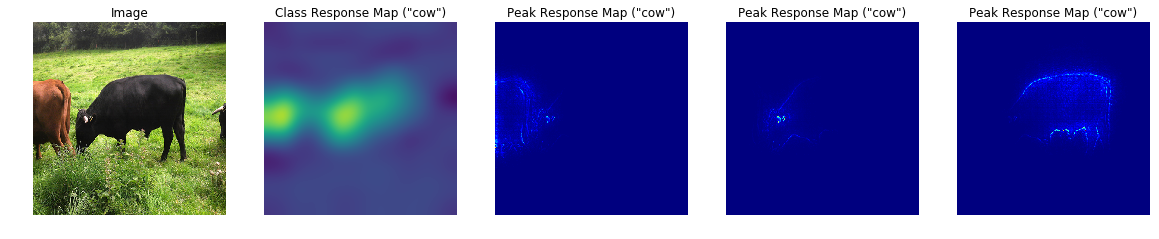

In [15]:
visual_cues = model(input_var)
if visual_cues is None:
    print('No class peak response detected')
else:
    confidence, class_response_maps, class_peak_responses, peak_response_maps = visual_cues
    _, class_idx = torch.max(confidence, dim=1)
    class_idx = class_idx.item()
    num_plots = 2 + len(peak_response_maps)
    f, axarr = plt.subplots(1, num_plots, figsize=(num_plots * 4, 4))
    axarr[0].imshow(imresize(raw_img, (image_size, image_size), interp='bicubic'))
    axarr[0].set_title('Image')
    axarr[0].axis('off')
    axarr[1].imshow(class_response_maps[0, class_idx].cpu(), interpolation='bicubic')
    axarr[1].set_title('Class Response Map ("%s")' % class_names[class_idx])
    axarr[1].axis('off')
    for idx, (prm, peak) in enumerate(sorted(zip(peak_response_maps, class_peak_responses), key=lambda v: v[-1][-1])):
        axarr[idx + 2].imshow(prm.cpu(), cmap=plt.cm.jet)
        axarr[idx + 2].set_title('Peak Response Map ("%s")' % (class_names[peak[1].item()]))
        axarr[idx + 2].axis('off')

### Weakly supervised instance segmentation

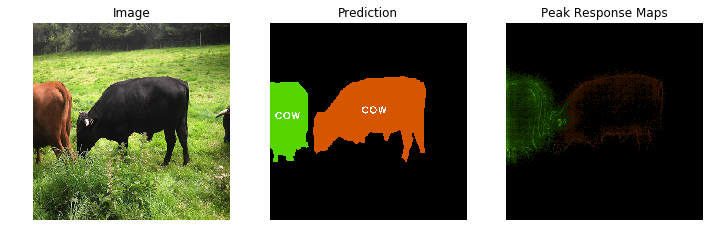

In [16]:
# predict instance masks via proposal retrieval
instance_list = model(input_var, retrieval_cfg=dict(proposals=proposals, param=(0.95, 1e-5, 0.8)))

# visualization
if instance_list is None:
    print('No object detected')
else:
    # peak response maps are merged if they select similar proposals
    vis = modules.prm_visualize(instance_list, class_names=class_names)
    f, axarr = plt.subplots(1, 3, figsize=(12, 5))
    axarr[0].imshow(imresize(raw_img, (image_size, image_size), interp='bicubic'))
    axarr[0].set_title('Image')
    axarr[0].axis('off')
    axarr[1].imshow(vis[0])
    axarr[1].set_title('Prediction')
    axarr[1].axis('off')
    axarr[2].imshow(vis[1])
    axarr[2].set_title('Peak Response Maps')
    axarr[2].axis('off')
    plt.show()